In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 as cv
from numpy.random import seed
seed(45)
import pickle
import pandas as pd
import re,json

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
from glob import glob 
import datetime
%matplotlib inline
%load_ext tensorboard


Init Plugin
Init Graph Optimizer
Init Kernel


In [25]:
%cd /Users/barakasoka/Desktop

/Users/barakasoka/Desktop


In [2]:
 CUSTOM_MODEL_NAME = 'FinalModel_1' 


In [11]:
paths = {
    'WORKSPACE_PATH': os.path.join('SAVE', 'workspace'),
    'SCRIPTS_PATH': os.path.join('SAVE','scripts'),
    'METADATA_PATH': os.path.join('SAVE','metadata'),
    'DATASET_PATH': os.path.join('SAVE','Datasets'),
    'NONCERVIX_PATH': os.path.join('SAVE','non_cervix'),
    'IMAGE_PATH': os.path.join('SAVE', 'workspace','images'),
    'TRAIN_PATH': os.path.join('SAVE', 'workspace','images','train'),
    'VALID_PATH': os.path.join('SAVE','workspace','images','valid' ),
    'TRAINPOS_PATH': os.path.join('SAVE','workspace','images','train','positive'),
    'TRAINNEG_PATH': os.path.join('SAVE','workspace','images','train','negative'),
    'VALIDPOS_PATH': os.path.join('SAVE','workspace','images','valid','positive'),
    'VALIDNEG_PATH': os.path.join('SAVE','workspace','images','valid','negative'),
    'SORTED_PATH': os.path.join('SAVE', 'workspace','images','sorted'),
    'MODEL_PATH': os.path.join('SAVE', 'workspace','models'),
    'OUTPUT_PATH': os.path.join('SAVE', 'workspace','models',CUSTOM_MODEL_NAME), 
 }

In [6]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

#### modeling

In [15]:
from keras.preprocessing.image import ImageDataGenerator
BATCHSIZE=16
SIZE=256
EPOCH=60
TRAIN=192
train_gen=ImageDataGenerator(rescale=1./255)
val_gen=ImageDataGenerator(rescale=1./255)
train_dir=paths['TRAIN_PATH']
val_dir=paths['VALID_PATH']

train_data=train_gen.flow_from_directory(train_dir, target_size=(SIZE,SIZE), class_mode="categorical",
                                        batch_size=BATCHSIZE)
val_data=val_gen.flow_from_directory(val_dir, target_size=(SIZE,SIZE), class_mode="categorical",
                                    batch_size=BATCHSIZE)
for data_batch, labels_batch in train_data:
    print('data batch shape:', data_batch.shape)
    print('label batch shape:', labels_batch.shape)
    break

Found 192 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
data batch shape: (16, 256, 256, 3)
label batch shape: (16, 2)


#### tranfer learning

In [7]:
base_model = tf.keras.applications.vgg19.VGG19(input_shape=(256,256,3),
                                         include_top=False,
                                         weights='imagenet')
base_model.trainable = False

In [28]:
def create_model():
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        Dense(2, activation='softmax')])
    METRICS = [ 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),]
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics= METRICS)
    return model
model= create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)               

In [10]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2022-03-01 14:55:33.020903: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-03-01 14:55:33.020920: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-03-01 14:55:33.021838: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


#### training 1

In [11]:
history = model.fit(train_data,
                    steps_per_epoch = TRAIN/BATCHSIZE,
                    epochs = EPOCH,
                    validation_data= val_data,
                   callbacks=[tensorboard_callback])

2022-03-01 14:55:45.582547: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-01 14:55:45.583949: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/60


2022-03-01 14:55:45.955560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/12 [=>............................] - ETA: 53s - loss: 1.0614 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.4492

2022-03-01 14:55:50.536495: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-03-01 14:55:50.536514: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


 2/12 [====>.........................] - ETA: 10s - loss: 1.0433 - accuracy: 0.5625 - precision: 0.5625 - recall: 0.5625 - auc: 0.4326

2022-03-01 14:55:51.487213: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-01 14:55:51.495457: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-03-01 14:55:51.517929: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220301-145533/train/plugins/profile/2022_03_01_14_55_51
2022-03-01 14:55:51.520112: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20220301-145533/train/plugins/profile/2022_03_01_14_55_51/BarakaMacBookPro.local.trace.json.gz
2022-03-01 14:55:51.531375: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220301-145533/train/plugins/profile/2022_03_01_14_55_51
2022-03-01 14:55:51.531640: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/20220301-145533/train/plugins/profi

12/12 [==============================] - ETA: 0s - loss: 0.7888 - accuracy: 0.5417 - precision: 0.5417 - recall: 0.5417 - auc: 0.5766

2022-03-01 14:55:56.542948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 13s 724ms/step - loss: 0.7888 - accuracy: 0.5417 - precision: 0.5417 - recall: 0.5417 - auc: 0.5766 - val_loss: 0.9565 - val_accuracy: 0.5116 - val_precision: 0.5116 - val_recall: 0.5116 - val_auc: 0.6933
Epoch 2/60
12/12 [==============================] - 9s 685ms/step - loss: 0.7374 - accuracy: 0.5781 - precision: 0.5781 - recall: 0.5781 - auc: 0.6031 - val_loss: 0.7130 - val_accuracy: 0.5349 - val_precision: 0.5349 - val_recall: 0.5349 - val_auc: 0.7047
Epoch 3/60
12/12 [==============================] - 10s 693ms/step - loss: 0.6694 - accuracy: 0.6198 - precision: 0.6198 - recall: 0.6198 - auc: 0.6390 - val_loss: 0.5146 - val_accuracy: 0.8372 - val_precision: 0.8372 - val_recall: 0.8372 - val_auc: 0.8615
Epoch 4/60
12/12 [==============================] - 23s 2s/step - loss: 0.5834 - accuracy: 0.6771 - precision: 0.6771 - recall: 0.6771 - auc: 0.7700 - val_loss: 0.5099 - val_accuracy: 0.8372 - val_precision: 0.8372 - val_recall: 0.8372 - val

Epoch 33/60
12/12 [==============================] - 8s 643ms/step - loss: 0.0662 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - val_loss: 0.2151 - val_accuracy: 0.9302 - val_precision: 0.9302 - val_recall: 0.9302 - val_auc: 0.9854
Epoch 34/60
12/12 [==============================] - 8s 611ms/step - loss: 0.0741 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9983 - val_loss: 0.2638 - val_accuracy: 0.8837 - val_precision: 0.8837 - val_recall: 0.8837 - val_auc: 0.9767
Epoch 35/60
12/12 [==============================] - 9s 658ms/step - loss: 0.0625 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - val_loss: 0.2538 - val_accuracy: 0.9302 - val_precision: 0.9302 - val_recall: 0.9302 - val_auc: 0.9827
Epoch 36/60
12/12 [==============================] - 9s 757ms/step - loss: 0.0842 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9983 - val_loss: 0.2283 - val_accuracy: 0.8605 - val_precision: 0.8605 - val_recal

#### tensorboard

In [4]:
%tensorboard --logdir logs/fit


Reusing TensorBoard on port 6009 (pid 69161), started 0:01:57 ago. (Use '!kill 69161' to kill it.)

In [25]:
model.save('cancer_detection_model_v1.h5')

In [26]:
pickle.dump(history.history, open(f'cancer_detection_history_v1.pkl', 'wb'))

#### checking metrics

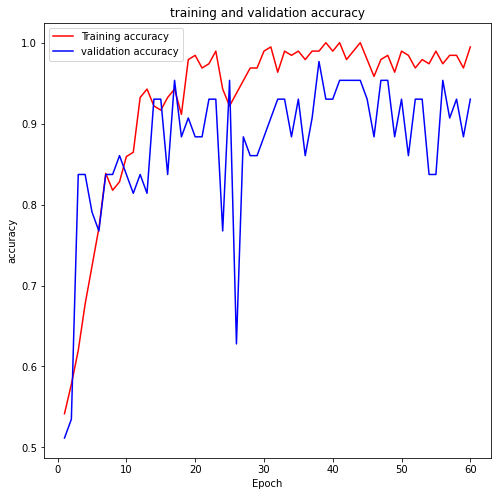

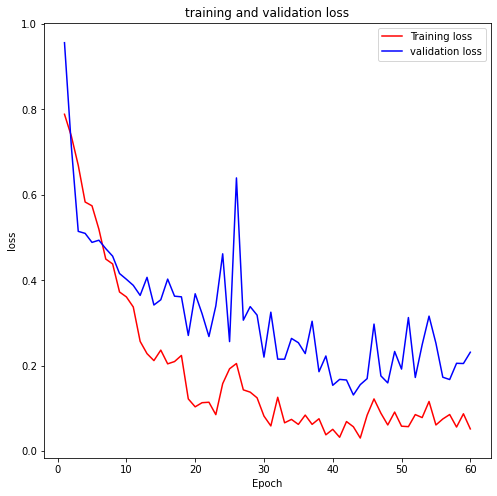

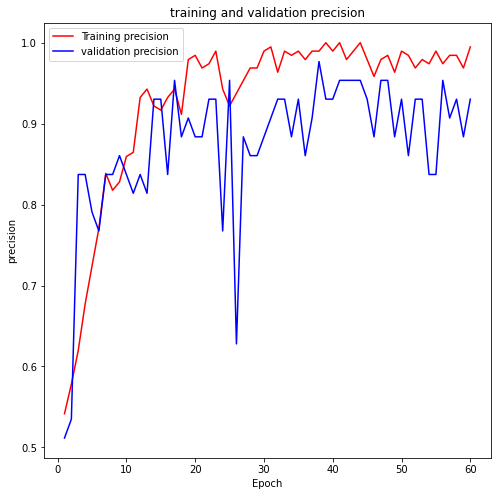

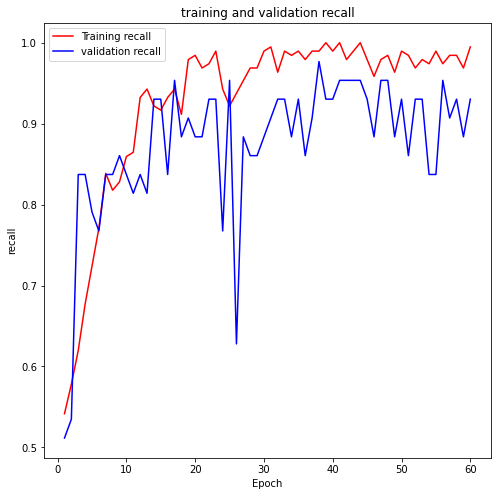

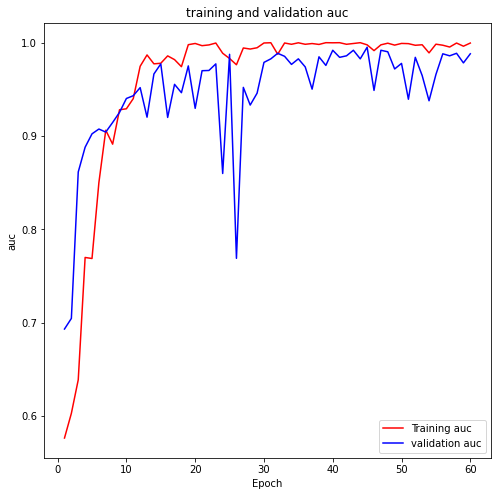

In [29]:
METRICS = ['accuracy', 'loss', 'precision', 'recall', 'auc']

for i in METRICS:
  metric = history.history[i]
  val_metric = history.history['val_'+i]

  epochs = range(1, len(metric) + 1)

  plt.figure(figsize=(8.0, 8.0))
  plt.plot(epochs, metric, 'r', label='Training '+i)
  plt.plot(epochs, val_metric, 'b', label = 'validation '+i)
  plt.xlabel('Epoch')
  plt.ylabel(i)
  plt.title('training and validation '+i)
  plt.legend()
  plt.show()